# Common Failure Modes & How to Fix Them
In this tutorial we'll go through ways that `LITMUS`'s features can break and how to diagnose / fix them

In [1]:
import litmus.models
from litmus import *
import matplotlib.pyplot as plt
import numpy as np
from litmus._utils import dict_extend

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## I'm getting errors about MAP Estimates not Converging
Both the `hessian_scan` and `SVI_scan` involve an initial pre-fit step where they try to find the Maximum A Posteori estimate (MAP estimate) for the parameters, i.e. the parameters that "best fit" the data for the model. This is a crucial step, as the results here inform what lags are tested and other crucial features of the actual scans. The MAP estimatation comes in three parts:
1. Start from some common sense estimate for the non-lag parameters, the "seed parameters"
2. Optimize all of these
3. Try a bunch of lags to see which is the best fit for the non-lag parameters from (2)
4. At this point, optimize the all parameters to get as close to the peak as possible
In almost all cases, this process should work as long as the seed parameters are reasonably good fits.


In [2]:
mock = mocks.mock_B
model_1 = models.GP_simple(verbose=False, debug=False)
data = model_1.lc_to_data(mock.lc_1, mock.lc_2)
#---------
seed_params_1 = model_1.find_seed(data)[0]

print("Param \t True \t Est Seed")
for p in model_1.paramnames():
    print("%s \t %.2f \t %.2f" % (p, mock.params()[p], seed_params_1[p]))

Param 	 True 	 Est Seed
lag 	 256.00 	 186.13
logtau 	 5.99 	 6.47
logamp 	 0.00 	 0.04
rel_amp 	 1.00 	 0.80
mean 	 0.00 	 -0.36
rel_mean 	 0.00 	 -0.21


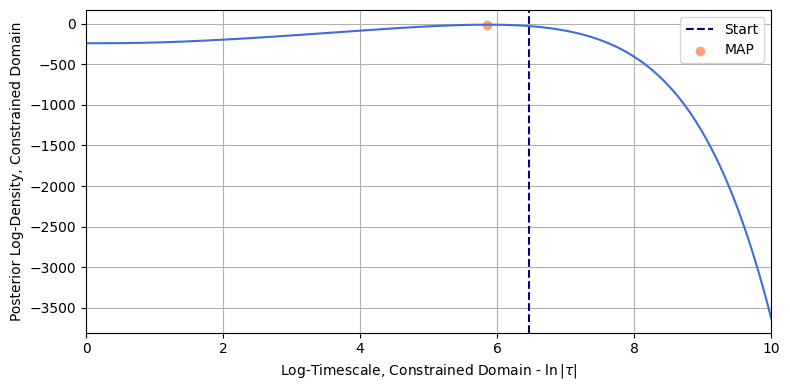

In [3]:
test_logtaus = np.linspace(*model_1.prior_ranges['logtau'], 1024)
test_params = dict_extend(seed_params_1, {'logtau': test_logtaus})
Y = model_1.log_density(test_params, data)

plt.figure(figsize=(8, 4))
plt.ylabel("Posterior Log-Density, Constrained Domain")
plt.xlabel("Log-Timescale, Constrained Domain - $\ln \\vert \\tau \\vert $")
plt.plot(test_logtaus, Y, c='royalblue')
plt.axvline(seed_params_1['logtau'], ls='--', label="Start", c='navy')
plt.scatter(test_logtaus[Y.argmax()], Y.max(), label="MAP", c='lightsalmon')
plt.xlim(*model_1.prior_ranges['logtau'])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

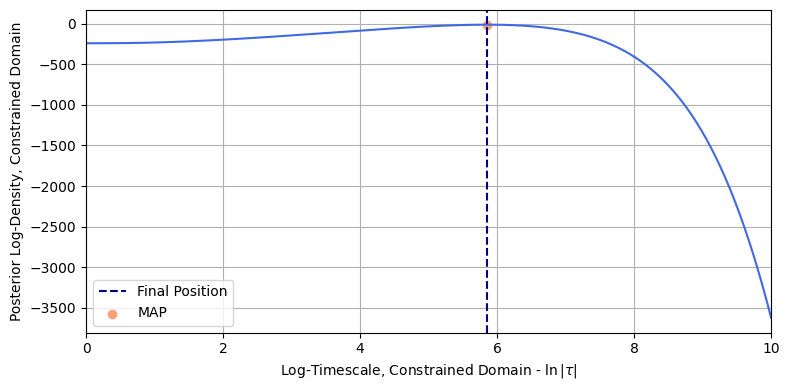

In [4]:
opt_params_1 = model_1.scan(start_params=seed_params_1, data=data, optim_params=["logtau"])

plt.figure(figsize=(8, 4))
plt.ylabel("Posterior Log-Density, Constrained Domain")
plt.xlabel("Log-Timescale, Constrained Domain - $\ln \\vert \\tau \\vert $")
plt.plot(test_logtaus, Y, c='royalblue')

plt.axvline(opt_params_1['logtau'], ls='--', label="Final Position", c='navy')

plt.scatter(test_logtaus[Y.argmax()], Y.max(), label="MAP", c='lightsalmon')
plt.xlim(*model_1.prior_ranges['logtau'])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

So everything's working great, right? Let's make things even easier and make another model with an even narrower prior range and try again:

In [17]:
model_2 = models.GP_simple(prior_ranges={'logtau': [5.0, 6.0]})
seed_params_2 = model_2.find_seed(data)[0]
opt_params_2 = model_2.scan(start_params=seed_params_2, data=data, optim_params=["logtau"], solver = "GradientDescent")

Oh no, it broke. Why? Shouldn't tighter priors make things easier? Well, not quite. The trick here is that the optimization in `.scan` works in the _unconstrained domain_, i.e. the model parameter space re-parameterized to have no hard borders. To see what this looks like we can use the `.to_uncon()` method to transit to this new coordinate system, and evaluate our model densities with `log_density_uncon()`:

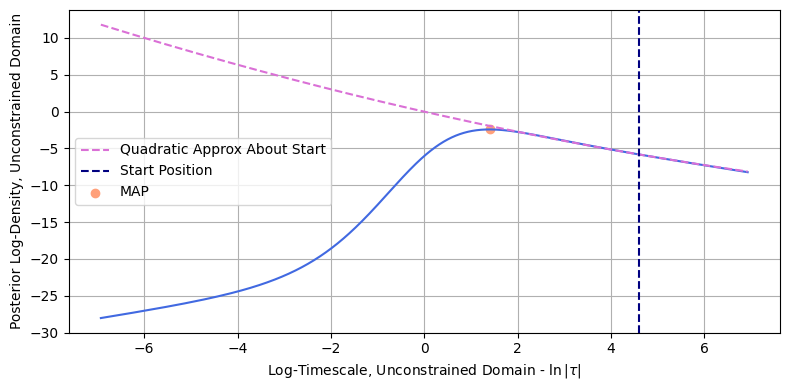

In [18]:
test_logtaus = np.linspace(*model_2.prior_ranges['logtau'], 1024)
test_params = dict_extend(seed_params_2, {'logtau': test_logtaus})
test_params = model_2.to_uncon(test_params)
Y = model_2.log_density_uncon(test_params, data)

X = test_params['logtau']
dX = X - model_2.to_uncon(seed_params_2)['logtau']
Y0 = model_2.log_density_uncon(model_2.to_uncon(seed_params_2), data)
dY = model_2.log_density_uncon_grad(model_2.to_uncon(seed_params_2), data)['logtau']
ddY = model_2.log_density_uncon_hess(model_2.to_uncon(seed_params_2), data, keys=['logtau'])

plt.figure(figsize=(8, 4))
plt.ylabel("Posterior Log-Density, Unconstrained Domain")
plt.xlabel("Log-Timescale, Unconstrained Domain - $\ln \\vert \\tau \\vert $")
plt.plot(X, Y, c='royalblue')
plt.plot(X, (dX ** 2 / 2 * ddY + dX * dY + Y0).flatten(), label="Quadratic Approx About Start", ls='--', c='orchid')
plt.axvline(model_2.to_uncon(seed_params_2)['logtau'], ls='--', label="Start Position", c='navy')
plt.scatter(X[Y.argmax()], Y.max(), label="MAP", c='lightsalmon')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
print("Param \t True \t Est Seed")
for p in model_1.paramnames():
    print("%s \t %.2f \t %.2f \t %.2f" % (p, mock.params()[p], opt_params_1[p], opt_params_2[p]))

Param 	 True 	 Est Seed
lag 	 256.00 	 186.13 	 186.13
logtau 	 5.99 	 5.85 	 5.80
logamp 	 0.00 	 0.04 	 0.04
rel_amp 	 1.00 	 0.80 	 0.80
mean 	 0.00 	 -0.36 	 -0.36
rel_mean 	 0.00 	 -0.21 	 -0.21


In [30]:
model_2.debug=True
p = {"lag": 189.57,
     "logtau": 5.65,
     "logamp": -0.27,
     "rel_amp": 1.38,
     "mean": -0.34,
     "rel_mean": -0.06}
p = model_2.scan(start_params=model_2.find_seed(data)[0], data=data, solver = "GradientDescent", optim_kwargs={"maxiter":2048})
p_uncon = model_2.to_uncon(p)
model_2.log_density_uncon_grad(p_uncon, data)

In find seed, sample no 102 is best /w LL -10.24 at lag 186.13 
Scaling matrix: [[0.00920974 0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.03552609 0.         0.         0.        ]
 [0.         0.         0.         0.06312596 0.         0.        ]
 [0.         0.         0.         0.         0.02382189 0.        ]
 [0.         0.         0.         0.         0.         0.01064742]] 
Inverse Scaling matrix: [[108.58065042   0.           0.           0.           0.
    0.        ]
 [  0.           1.           0.           0.           0.
    0.        ]
 [  0.           0.          28.1483266    0.           0.
    0.        ]
 [  0.           0.           0.          15.84134379   0.
    0.        ]
 [  0.           0.           0.           0.          41.97819486
    0.        ]
 [  0.           0.           0.           0.           0.
   93.91947012]] 
At initial uncon pos

{'lag': Array(-1183.15253267, dtype=float64, weak_type=True),
 'logamp': Array(35.22015039, dtype=float64, weak_type=True),
 'logtau': Array(-2.4786579, dtype=float64, weak_type=True),
 'mean': Array(-138.4861018, dtype=float64, weak_type=True),
 'rel_amp': Array(2.40402422, dtype=float64, weak_type=True),
 'rel_mean': Array(194.73383469, dtype=float64, weak_type=True)}

In [41]:
model_1.debug=False
x = model_1.scan(model_1.find_seed(data)[0], data, solver = "GradientDescent", optim_kwargs={"maxiter":2048})
model_1.opt_tol(x, data, constrained=True, integrate_axes=[key for key in model_1.paramnames() if key!="lag"])

2.601956967695004

In [45]:
fitter = litmus.fitting_methods.hessian_scan(model_2, debug=True)
fitter.prefit(mock.lc_1, mock.lc_2)

Doing config with keys dict_keys(['Nlags', 'opt_tol', 'opt_tol_init', 'step_size', 'constrained_domain', 'max_opt_eval', 'max_opt_eval_init', 'LL_threshold', 'init_samples', 'grid_bunching', 'grid_depth', 'grid_Nterp', 'grid_firstdepth', 'reverse', 'split_lags', 'optimizer_args_init', 'optimizer_args', 'seed_params', 'precondition', 'interp_scale']) 
	 set attr Nlags 
	 set attr opt_tol 
	 set attr opt_tol_init 
	 set attr step_size 
	 set attr constrained_domain 
	 set attr max_opt_eval 
	 set attr max_opt_eval_init 
	 set attr LL_threshold 
	 set attr init_samples 
	 set attr grid_bunching 
	 set attr grid_depth 
	 set attr grid_Nterp 
	 set attr grid_firstdepth 
	 set attr reverse 
	 set attr split_lags 
	 set attr optimizer_args_init 
	 set attr optimizer_args 
	 set attr seed_params 
	 set attr precondition 
	 set attr interp_scale 
In find seed, sample no 926 is best /w LL -10.03 at lag 185.20 
Beginning scan at constrained-space position: 
	 lag: 	 185.20 
	 logtau: 	 5.99 
	 lo

In .opt_tol, Hessian is singular or has NaNs. Returning inf. 

Pass number:	 1 Any Errors?	 False 
Pass number:	 2 Any Errors?	 False 
Pass number:	 3 Any Errors?	 False 
Pass number:	 4 Any Errors?	 False 


**Solutions**
1. Use wider priors to avoid the warping
2. Manually tune your seed parameters, which can be fed to the fitter as an argument e.g. `hessian_scan(model, seed_params={"logtau":5.9})`
3. Switch the scan_method from `BFGS` to the much slower `gradient_descent`

## My Posteriors look Really Chunky
